In [ ]:
import numpy as np
import scipy
from scipy.special import expit
from scipy.special import logsumexp
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer    
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import sys
sys.path.append('/home/boris/projects/aimasters/1sem/ML1/utils')
from utils import get_split, train_linear_model, get_df_info_mine, get_df_info, plot_density
storage = optuna.storages.RDBStorage("sqlite:///optuna.db")



In [11]:
data = pd.read_csv('aim-2025-callcenter/train.csv')
session_data = pd.read_csv('aim-2025-callcenter/t1_webstat.csv')
ans_data = pd.read_csv('aim-2025-callcenter/test.csv')

In [12]:
data['create_timestamp'] = pd.to_datetime(data['create_time']).astype('int64') // 10**9
data['model_create_timestamp'] = pd.to_datetime(data['model_create_time']).astype('int64') // 10**9
data = data.drop('create_time', axis=1)
data = data.drop('model_create_time', axis=1)
session_data['date_timestamp'] = pd.to_datetime(session_data['date_time']).astype('int64') // 10**9
session_data = session_data.drop('date_time', axis=1)


In [26]:
called = data[data['is_callcenter']==1]
not_called = data[data['is_callcenter']==0]

In [4]:
train, test = get_split(data)


In [5]:
train = train.drop('order_id', axis=1)
print(train.columns)
fetaures = train.columns[:-1]
target_col = 'is_callcenter'
print(fetaures)

Index(['good_id', 'price', 'utm_medium', 'utm_source', 'sessionkey_id',
       'category_id', 'parent_id', 'root_id', 'model_id', 'is_moderated',
       'rating_value', 'rating_count', 'description_length', 'goods_qty',
       'pics_qty', 'is_callcenter', 'create_timestamp',
       'model_create_timestamp'],
      dtype='object')
Index(['good_id', 'price', 'utm_medium', 'utm_source', 'sessionkey_id',
       'category_id', 'parent_id', 'root_id', 'model_id', 'is_moderated',
       'rating_value', 'rating_count', 'description_length', 'goods_qty',
       'pics_qty', 'is_callcenter', 'create_timestamp'],
      dtype='object')


In [20]:
get_df_info_mine(session_data)


,dtype,nunique,ex1,ex2,nans,zeros,empty_str,col_mode,vc_max,trash_score
sessionkey_id,int64,328430,119341531.0,127437523.0,-1.000,-1.000,-1.0,119635649.0,0.000189,-1.000
page_type,int64,13,1.0,1.0,-1.000,-1.000,-1.0,1.0,0.387358,-1.000
pageview_number,int64,632,18.0,21.0,-1.000,-1.000,-1.0,1.0,0.097014,-1.000
pageview_duration_sec,float64,2974,11.0,35.0,0.088,0.005,-1.0,9.0,0.023138,0.088
category_id,float64,3548,1257.0,139.0,0.293,-1.000,-1.0,155.0,0.038281,0.293
model_id,float64,181759,1655741.0,2072392.0,0.613,-1.000,-1.0,18340251.0,0.000897,0.613
good_id,float64,233143,21891848.0,70312179.0,0.632,-1.000,-1.0,66921494.0,0.000487,0.632
price,float64,12298,290.0,644.0,0.632,-1.000,-1.0,952.0,0.001531,0.632
product_in_sale,float64,1,1.0,1.0,0.632,-1.000,-1.0,1.0,0.367473,0.632
date_timestamp,int64,2510161,186890365.0,190466191.0,-1.000,-1.000,-1.0,191620626.0,0.000007,-1.000


In [28]:
get_df_info_mine(not_called)


,dtype,nunique,ex1,ex2,nans,zeros,empty_str,col_mode,vc_max,trash_score
order_id,int64,67496,1275287.0,1226605.0,-1.000,-1.000,-1.0,1.158405e+06,0.000015,-1.000
good_id,int64,38311,33022550.0,60298539.0,-1.000,-1.000,-1.0,6.692149e+07,0.002637,-1.000
price,int64,5346,1067.0,159.0,-1.000,-1.000,-1.0,2.640000e+02,0.011897,-1.000
utm_medium,int64,8,1.0,6.0,-1.000,-1.000,-1.0,1.000000e+00,0.439137,-1.000
utm_source,float64,243,1.0,4.0,0.111,-1.000,-1.0,1.000000e+00,0.389905,0.111
sessionkey_id,int64,62179,124388489.0,119272056.0,-1.000,-1.000,-1.0,1.259969e+08,0.000311,-1.000
category_id,int64,1622,4431.0,143.0,-1.000,-1.000,-1.0,1.550000e+02,0.084553,-1.000
parent_id,int64,356,4423.0,140.0,-1.000,-1.000,-1.0,1.540000e+02,0.088613,-1.000
root_id,int64,26,255.0,124.0,-1.000,-1.000,-1.0,1.183000e+03,0.278061,-1.000
model_id,int64,28194,927999.0,430919.0,-1.000,-1.000,-1.0,1.834025e+07,0.005097,-1.000


In [45]:
get_df_info_mine(called)


,dtype,nunique,ex1,ex2,nans,zeros,empty_str,col_mode,vc_max,trash_score
order_id,int64,37099,1200679.0,1284327.0,-1.000,-1.000,-1.0,1.158435e+06,0.000027,-1.000
good_id,int64,24649,60323488.0,68496628.0,-1.000,-1.000,-1.0,6.692149e+07,0.002210,-1.000
price,int64,4913,1242.0,2861.0,-1.000,-1.000,-1.0,9.520000e+02,0.005202,-1.000
utm_medium,int64,8,4.0,1.0,-1.000,-1.000,-1.0,1.000000e+00,0.489609,-1.000
utm_source,float64,161,1.0,2.0,0.079,-1.000,-1.0,1.000000e+00,0.498234,0.079
sessionkey_id,int64,35288,116696086.0,125272911.0,-1.000,-1.000,-1.0,1.196842e+08,0.000270,-1.000
category_id,int64,1239,1505.0,155.0,-1.000,-1.000,-1.0,1.550000e+02,0.098871,-1.000
parent_id,int64,320,2844.0,154.0,-1.000,-1.000,-1.0,1.540000e+02,0.104828,-1.000
root_id,int64,26,1504.0,153.0,-1.000,-1.000,-1.0,1.183000e+03,0.237311,-1.000
model_id,int64,17757,1969373.0,10059983.0,-1.000,-1.000,-1.0,2.582010e+05,0.005148,-1.000


In [46]:
session_key = 116696086.0
display(session_data[session_data['sessionkey_id']==session_key].sort_values('date_timestamp'))
display(data[data['sessionkey_id']==session_key])

,sessionkey_id,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale,date_timestamp
2980666,116696086,2,1,17.0,1505.0,NaN,NaN,NaN,NaN,185806358
3000976,116696086,1,2,49.0,1505.0,1969373.0,60323488.0,1242.0,1.0,185806375
2997045,116696086,1,3,186.0,1505.0,1969373.0,60323488.0,1242.0,1.0,185806424
2980667,116696086,3,4,14.0,NaN,NaN,NaN,NaN,NaN,185806610
2997046,116696086,1,5,NaN,1505.0,1969373.0,60323488.0,1242.0,1.0,185806624


,order_id,good_id,price,utm_medium,utm_source,sessionkey_id,category_id,parent_id,root_id,model_id,is_moderated,rating_value,rating_count,description_length,goods_qty,pics_qty,is_callcenter,create_timestamp,model_create_timestamp
25609,1200679,60323488,1242,4,1.0,116696086,1505,2844,1504,1969373,1,4.0,2.0,506,7,3,1,185807053,89642406


In [ ]:
model, logreg_features, scaler =  train_linear_model(train, features = fetaures, target_col = target_col)


In [17]:
X_tr = train[fetaures].to_numpy()
y_tr = train[target_col].to_numpy()
X_tst = test[fetaures].to_numpy()
y_tst = test[target_col].to_numpy()


In [20]:
prep = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

prep.fit(X_tr)

X_tr = prep.transform(X_tr)
X_tst = prep.transform(X_tst)

In [28]:
display(X_tr)
display(y_tr)
display(X_tst)
display(y_tst)

array([[ 0.47289549, -0.75332747, -0.35782392, ...,  0.00384402,
        -0.74064039, -1.12029294],
       [ 0.89235291,  2.34130279,  0.66427177, ...,  0.3414149 ,
         1.3501829 ,  1.55046902],
       [ 0.89225517, -0.54214422,  0.66427177, ...,  0.3414149 ,
        -0.74064039, -0.80804181],
       ...,
       [ 0.89235721,  0.74000905, -0.35782392, ...,  1.01655666,
         1.3501829 ,  1.34031248],
       [ 0.43193333, -0.67590795,  1.68636746, ..., -0.33372685,
        -0.74064039,  1.6326844 ],
       [ 0.27530844, -0.42472461, -0.86887176, ..., -0.33372685,
         1.3501829 ,  0.79790797]], shape=(70078, 17))

array([0, 1, 0, ..., 1, 0, 1], shape=(70078,))

array([[-2.13345243, -0.45526231,  1.17531961, ..., -0.33372685,
         1.3501829 ,  0.34369187],
       [-2.13345243, -0.45526231, -0.86887176, ..., -0.33372685,
        -0.74064039,  0.34522935],
       [-2.13345243, -0.45526231, -0.35782392, ..., -0.33372685,
         1.3501829 ,  0.30903864],
       ...,
       [ 0.54586595, -0.19676714, -0.86887176, ..., -0.67129773,
         1.3501829 , -1.45999174],
       [ 0.89500097, -0.15461651, -0.35782392, ..., -0.67129773,
        -0.74064039, -1.31295949],
       [ 0.8064625 , -0.7550479 ,  1.68636746, ..., -0.67129773,
        -0.74064039, -1.00971367]], shape=(34517, 17))

array([1, 0, 1, ..., 1, 0, 0], shape=(34517,))

In [32]:
def objectiveSklearn(trial):
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 1e-3, 100, log=True)
    tol = trial.suggest_float('tol', 1e-5, 1e-2, log=True)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    l1_ratio = None
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga']) 
    if penalty == 'l1' and solver == 'lbfgs':
        raise optuna.TrialPruned()
    clf = LogisticRegression(
        penalty=penalty,
        C=C,
        solver=solver,
        tol=tol,
        max_iter=max_iter,
        l1_ratio=l1_ratio,
        random_state=42
    )
    
    clf.fit(X_tr, y_tr)
    return -roc_auc_score(y_tst, clf.predict_proba(X_tst)[:, 1])

study = optuna.create_study(storage=storage)

[I 2025-11-01 14:59:05,826] A new study created in RDB with name: no-name-6aaf2d52-2995-4fed-8caf-3fa9c9d69c2c


In [27]:
clf = LogisticRegression(
        penalty='l2',
        C=47.163013827752906,
        solver='liblinear',
        tol=1.0171669120095538e-05,
        max_iter=446,
        l1_ratio=None,
        random_state=42,
        verbose=1
    )
clf.fit(X_tr, y_tr)

[LibLinear]iter  1 act 1.867e+06 pre 1.648e+06 delta 2.293e+00 f 2.291e+06 |g| 1.666e+06 CG   2
iter  2 act 2.819e+05 pre 2.262e+05 delta 2.293e+00 f 4.238e+05 |g| 4.004e+05 CG   2
iter  3 act 9.124e+04 pre 7.250e+04 delta 2.293e+00 f 1.419e+05 |g| 1.398e+05 CG   2
iter  4 act 3.220e+04 pre 2.551e+04 delta 2.293e+00 f 5.064e+04 |g| 5.060e+04 CG   2
iter  5 act 1.167e+04 pre 9.236e+03 delta 2.293e+00 f 1.845e+04 |g| 1.851e+04 CG   2
iter  6 act 4.265e+03 pre 3.375e+03 delta 2.293e+00 f 6.776e+03 |g| 6.792e+03 CG   2
iter  7 act 1.560e+03 pre 1.235e+03 delta 2.293e+00 f 2.511e+03 |g| 2.494e+03 CG   2
iter  8 act 5.675e+02 pre 4.498e+02 delta 2.293e+00 f 9.502e+02 |g| 9.148e+02 CG   2
iter  9 act 2.021e+02 pre 1.608e+02 delta 2.293e+00 f 3.827e+02 |g| 3.338e+02 CG   2
iter 10 act 6.764e+01 pre 5.437e+01 delta 2.293e+00 f 1.805e+02 |g| 1.198e+02 CG   2
iter 11 act 1.899e+01 pre 1.569e+01 delta 2.293e+00 f 1.129e+02 |g| 4.102e+01 CG   2
iter 12 act 3.351e+00 pre 2.942e+00 delta 2.293e+00 f 

,penalty,'l2'
,dual,False
,tol,1.0171669120095538e-05
,C,47.163013827752906
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,446
,multi_class,'deprecated'


In [29]:
roc_auc_score(y_tst, clf.predict_proba(X_tst)[:, 1])

1.0

In [33]:
study.optimize(objectiveSklearn, n_trials=10)

study.best_params 

[I 2025-11-01 14:59:11,594] Trial 0 finished with value: -1.0 and parameters: {'penalty': 'l2', 'C': 0.03312579607920103, 'tol': 0.005420256306112185, 'max_iter': 576, 'solver': 'liblinear'}. Best is trial 0 with value: -1.0.
[I 2025-11-01 14:59:11,790] Trial 1 finished with value: -1.0 and parameters: {'penalty': 'l1', 'C': 3.9554392137862755, 'tol': 2.497057385950539e-05, 'max_iter': 226, 'solver': 'liblinear'}. Best is trial 0 with value: -1.0.
[I 2025-11-01 14:59:11,997] Trial 2 finished with value: -1.0 and parameters: {'penalty': 'l2', 'C': 25.88700456852846, 'tol': 0.0011272635532712596, 'max_iter': 724, 'solver': 'liblinear'}. Best is trial 0 with value: -1.0.
[I 2025-11-01 14:59:12,068] Trial 3 pruned. 
[I 2025-11-01 14:59:12,149] Trial 4 pruned. 
/home/boris/projects/aimasters/1sem/ML1/.venv/lib64/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-11-01 14:59:2

{'penalty': 'l2',
 'C': 0.03312579607920103,
 'tol': 0.005420256306112185,
 'max_iter': 576,
 'solver': 'liblinear'}

In [6]:
weights = model.coef_[0]
feature_names = logreg_features
feature_weights = pd.DataFrame({
    'feature': feature_names,
    'weight': weights,
    'abs_weight': np.abs(weights)
})
top_k = 10
top_features = feature_weights.nlargest(top_k, 'abs_weight')

In [19]:
df_test = pd.DataFrame({'time': [pd.to_datetime('2019-01-15 13:25:43')]})
df_unix_sec = pd.to_datetime(df_test['time']).astype(int)/ 10**9
print(df_unix_sec)

0    1.547559e+09
Name: time, dtype: float64


/tmp/ipykernel_50073/2456173529.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


[Text(0, 0, 'price'),
 Text(1, 0, 'utm_medium'),
 Text(2, 0, 'category_id'),
 Text(3, 0, 'good_id'),
 Text(4, 0, 'model_id'),
 Text(5, 0, 'pics_qty'),
 Text(6, 0, 'goods_qty'),
 Text(7, 0, 'is_moderated'),
 Text(8, 0, 'root_id'),
 Text(9, 0, 'description_length')]

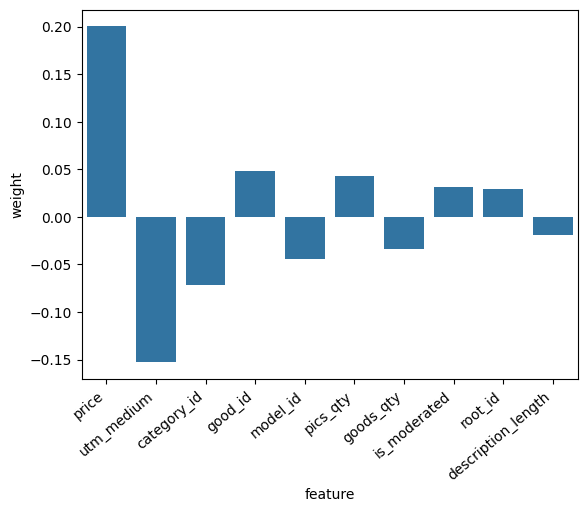

In [7]:
ax = sns.barplot(data=top_features, x='feature', y = 'weight')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")